In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.TD_NN import TemporalDifferenceNN
from utils.NeuralNet import TwoHiddenLayerNN

from utils import Benchmarking

seed = 42
torch.manual_seed(seed)

In [2]:
housedata = torch.tensor(np.loadtxt('data\\readyhousedata.txt', delimiter=','), dtype=torch.float32)

X = housedata[:, :-1]
y = housedata[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Parameters for TD
num_samples, num_features = X_train.shape
P = torch.ones((num_samples, num_samples)) / num_samples # Equal probability to move to any state

identity = lambda x : x

In [4]:
# Initialise classes
td_sgd = TemporalDifferenceNN(
    optimizer='sgd',
    input_size=num_features,
    learning_rate=0.001,
    epsilon=1e-7,
    n_iter=1e5,
    P=P,
)

td_adam = TemporalDifferenceNN(
    optimizer='adam',
    input_size=num_features,
    learning_rate=0.001,
    epsilon=1e-6,
    n_iter=1e5,
    P=P,
    betas=(0.85, 0.999),
)

nn_sgd = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='sgd',
    learning_rate=0.01,
)

nn_adam = TwoHiddenLayerNN(
    input_size=num_features,
    optimizer='adam',
    learning_rate=0.1,
)

In [5]:
# Train the TD models
td_sgd.fit(X_train, y_train)
td_adam.fit(X_train, y_train)

# Train the NN models
nn_sgd.fit(X_train, y_train, epochs=1600)
nn_adam.fit(X_train, y_train, epochs=800)

Ending optimization early at iteration 25954
Ending optimization early at iteration 3847


In [6]:
# Define noise standard deviation
noise_std = 0.1

# Add Gaussian noise to the test set
X_test_noisy = X_test + torch.randn(X_test.shape) * noise_std

In [7]:
# TD predictions on original and noisy test sets
y_pred_td_sgd = td_sgd.predict(X_test)
y_pred_td_sgd_noisy = td_sgd.predict(X_test_noisy)

y_pred_td_adam = td_adam.predict(X_test)
y_pred_td_adam_noisy = td_adam.predict(X_test_noisy)

# NN predictions on original and noisy test sets
y_pred_nn_sgd = nn_sgd.predict(X_test)
y_pred_nn_sgd_noisy = nn_sgd.predict(X_test_noisy)

y_pred_nn_adam = nn_adam.predict(X_test)
y_pred_nn_adam_noisy = nn_adam.predict(X_test_noisy)

In [8]:
# Measure the average change in output values for all methods
change_td_sgd = Benchmarking.mean_absolute_diff(y_pred_td_sgd, y_pred_td_sgd_noisy)
change_td_adam = Benchmarking.mean_absolute_diff(y_pred_td_adam, y_pred_td_adam_noisy)
change_nn_sgd = Benchmarking.mean_absolute_diff(y_pred_nn_sgd, y_pred_nn_sgd_noisy)
change_nn_adam = Benchmarking.mean_absolute_diff(y_pred_nn_adam, y_pred_nn_adam_noisy)

# Print the results
print(f"Average change for TD-SGD: {change_td_sgd}")
print(f"Average change for TD-Adam: {change_td_adam}")
print(f"Average change for NN-SGD: {change_nn_sgd}")
print(f"Average change for NN-Adam: {change_nn_adam}")

Average change for TD-SGD: 3.992710590362549
Average change for TD-Adam: 2.82314395904541
Average change for NN-SGD: 3.099750280380249
Average change for NN-Adam: 6.959611892700195


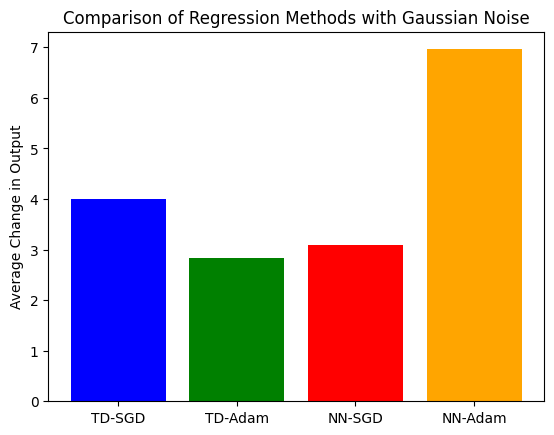

In [9]:
# Plot the changes in predictions
Benchmarking.plot_noise_diff(
    td_sgd=change_td_sgd, 
    td_adam=change_td_adam, 
    nn_sgd=change_nn_sgd, 
    nn_adam=change_nn_adam,
    )

In [10]:
print(f"RMSE for TD-SGD {td_sgd.rmse(X_test, y_test)}")
print(f"RMSE for TD-ADAM {td_adam.rmse(X_test, y_test)}")
print(f"RMSE for NN-SGD {nn_sgd.rmse(X_test, y_test)}")
print(f"RMSE for NN-ADAM {nn_adam.rmse(X_test, y_test)}")

RMSE for TD-SGD 3.201786994934082
RMSE for TD-ADAM 3.6343557834625244
RMSE for NN-SGD 2.994555711746216
RMSE for NN-ADAM 3.175004482269287


In [11]:
print(f"RMSE for noisy TD-SGD {td_sgd.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy TD-ADAM {td_adam.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy NN-SGD {nn_sgd.rmse(X_test_noisy, y_test)}")
print(f"RMSE for noisy NN-ADAM {nn_adam.rmse(X_test_noisy, y_test)}")

RMSE for noisy TD-SGD 6.735496997833252
RMSE for noisy TD-ADAM 4.884382724761963
RMSE for noisy NN-SGD 5.473546981811523
RMSE for noisy NN-ADAM 11.649794578552246
